In [1]:
import numpy as np
import pandas as pd

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Read and process the CSV file
csv_path = "problems/frag0.csv"
output_data = read_csv_(csv_path)

df = pd.read_csv('problems/frag0.csv')
     

In [2]:
df

,0.000000000000000000e+00,0.000000000000000000e+00.1,4.194200134277343750e+01,6.898000335693359375e+01
0,0.0,0.0,41.259605,69.811707
1,0.0,0.0,40.588753,70.652374
2,0.0,0.0,39.929607,71.501953
3,0.0,0.0,39.282337,72.360405
4,0.0,0.0,38.647114,73.227669
...,...,...,...,...
1769,9.0,0.0,212.755249,2.102682
1770,9.0,0.0,213.760941,2.103762
1771,9.0,0.0,214.766632,2.104841
1772,9.0,0.0,215.772308,2.105921


In [3]:
len(output_data)

10

In [4]:
for i in range(len(output_data)):
  print(output_data[i][0].shape)

(94, 2)
(166, 2)
(171, 2)
(166, 2)
(109, 2)
(205, 2)
(226, 2)
(208, 2)
(215, 2)
(215, 2)


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_circles(gray_image):
    circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=30, minRadius=0, maxRadius=0)
    return circles

def approximate_contours(contours, epsilon_factor=0.01):
    approx_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If the approximation has many points, it's likely a circle
        if len(approx) > 10:
            approx_contours.append(contour)  # Use original contour for circles
        else:
            approx_contours.append(approx)
    return approx_contours

def draw_shapes(image, contours, circles):
    result_image = np.ones_like(image) * 255
    
    # Draw detected circles
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cv2.circle(result_image, center, radius, (0, 0, 0), 2)
    
    # Draw other contours
    for contour in contours:
        if len(contour) > 10:  # Likely a circle, skip as we've already drawn circles
            continue
        cv2.drawContours(result_image, [contour], -1, (0, 0, 0), 2)
    
    return result_image

def process_image(image):
    gray_image = convert_to_grayscale(image)
    edges = apply_canny_edge_detection(gray_image)
    contours = find_contours(edges)
    circles = detect_circles(gray_image)
    return gray_image, edges, contours, circles

def main(input_csv, output_dir):
    try:
        paths = read_csv(input_csv)
        image = plot_paths(paths)
        
        gray_image, edges, contours, circles = process_image(image)
        visualize_results(image, gray_image, edges, contours, None)  # Removed lines
        
        approx_contours = approximate_contours(contours)
        result_image = draw_shapes(image, approx_contours, circles)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title('Final Fixed Image')
        plt.axis('off')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

        save_results(result_image, contours, output_dir)

    except FileNotFoundError:
        print(f"Error: CSV file not found at {input_csv}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Run the main function
input_csv = 'problems/isolated.csv'  # Replace with your actual input CSV path
output_dir = 'output'  # Replace with your desired output directory

main(input_csv, output_dir)

An error occurred: name 'read_csv' is not defined


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(gray_image, edges):
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shapes = []
    for i, contour in enumerate(contours):
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            shapes.append(('square', approx))
        elif len(approx) == 5:
            shapes.append(('star', approx))
        else:
            # Check if it's a circle
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            try:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.8:  # Adjust this threshold as needed
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    shapes.append(('circle', ((int(x), int(y)), int(radius))))
                else:
                    print(f"Contour {i}: Not circular enough (circularity = {circularity:.2f})")
            except ZeroDivisionError:
                print(f"Contour {i}: Division by zero error (area = {area}, perimeter = {perimeter})")
                # You might want to handle this case differently, e.g., by skipping this contour
    
    return shapes
def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Adjust Canny edge detection parameters if needed
    edges = cv2.Canny(gray_image, 50, 150)
    shapes = detect_shapes(gray_image, edges)
    
    # Debug: print detected shapes
    print(f"Detected shapes: {shapes}")
    
    return gray_image, edges, shapes


def draw_shapes(image, shapes):
    result_image = np.ones_like(image) * 255
    
    for shape_type, shape_data in shapes:
        if shape_type == 'circle':
            center, radius = shape_data
            cv2.circle(result_image, center, radius, (0, 0, 0), 2)
        elif shape_type in ['square', 'star']:
            cv2.drawContours(result_image, [shape_data], 0, (0, 0, 0), 2)
    
    return result_image

def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150)
    shapes = detect_shapes(gray_image, edges)
    return gray_image, edges, shapes
def visualize_intermediate_steps(image, gray_image, edges):
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(133)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    plt.show()

# In the main function, add:
visualize_intermediate_steps(image, gray_image, edges)

def main(input_csv, output_dir):
    try:
        paths = read_csv(input_csv)
        image = plot_paths(paths)
        
        gray_image, edges, shapes = process_image(image)
        result_image = draw_shapes(image, shapes)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title('Final Fixed Image')
        plt.axis('off')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

        save_results(result_image, shapes, output_dir)

    except FileNotFoundError:
        print(f"Error: CSV file not found at {input_csv}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Run the main function
input_csv = 'problems/isolated.csv'  # Replace with your actual input CSV path
output_dir = 'output'  # Replace with your desired output directory

main(input_csv, output_dir)

NameError: name 'image' is not defined

Contour 1: Division by zero error (area = 0.0, perimeter = 0.0)
Contour 2: Division by zero error (area = 0.0, perimeter = 0.0)
Contour 3: Not circular enough (circularity = 0.01)
Contour 4: Not circular enough (circularity = 0.00)
Contour 6: Not circular enough (circularity = 0.00)
Contour 7: Not circular enough (circularity = 0.00)
Contour 8: Not circular enough (circularity = 0.00)
Detected shapes: [('circle', ((137, 187), 73)), ('square', array([[[  6,   2]],

       [[  3, 112]],

       [[103, 117]],

       [[109,   9]]], dtype=int32))]


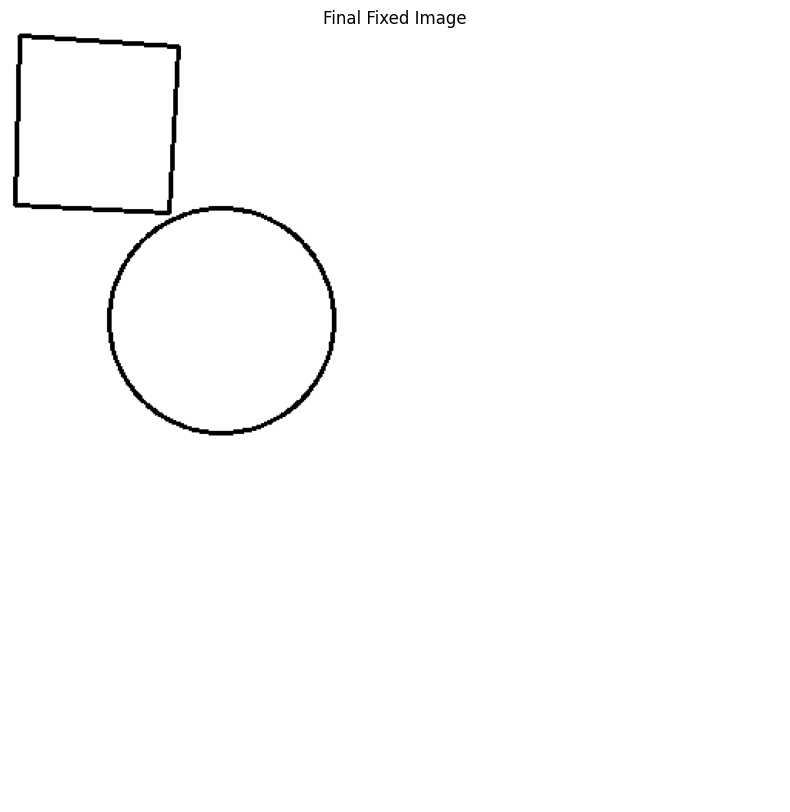

An error occurred: Unknown format code 'e' for object of type 'str'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(gray_image, edges):
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shapes = []
    for i, contour in enumerate(contours):
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            shapes.append(('square', approx))
        elif len(approx) == 5:
            shapes.append(('star', approx))
        else:
            # Check if it's a circle
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            try:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.8:  # Adjust this threshold as needed
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    shapes.append(('circle', ((int(x), int(y)), int(radius))))
                else:
                    print(f"Contour {i}: Not circular enough (circularity = {circularity:.2f})")
            except ZeroDivisionError:
                print(f"Contour {i}: Division by zero error (area = {area}, perimeter = {perimeter})")
                # You might want to handle this case differently, e.g., by skipping this contour
    
    return shapes

def approximate_contours(contours, epsilon_factor=0.01):
    approx_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If the approximation has many points, it's likely a circle
        if len(approx) > 10:
            approx_contours.append(contour)  # Use original contour for circles
        else:
            approx_contours.append(approx)
    return approx_contours

def draw_shapes(image, shapes):
    result_image = np.ones_like(image) * 255
    
    for shape_type, shape_data in shapes:
        if shape_type == 'circle':
            center, radius = shape_data
            cv2.circle(result_image, center, radius, (0, 0, 0), 2)
        elif shape_type in ['square', 'star']:
            cv2.drawContours(result_image, [shape_data], 0, (0, 0, 0), 2)
    
    return result_image

def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Adjust Canny edge detection parameters if needed
    edges = cv2.Canny(gray_image, 50, 150)
    shapes = detect_shapes(gray_image, edges)
    
    # Debug: print detected shapes
    print(f"Detected shapes: {shapes}")
    
    return gray_image, edges, shapes


def main(input_csv, output_dir):
    try:
        paths = read_csv(input_csv)
        image = plot_paths(paths)
        
        gray_image, edges, shapes = process_image(image)
        result_image = draw_shapes(image, shapes)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title('Final Fixed Image')
        plt.axis('off')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

        save_results(result_image, shapes, output_dir)

    except FileNotFoundError:
        print(f"Error: CSV file not found at {input_csv}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Run the main function
input_csv = 'problems/isolated.csv'  # Replace with your actual input CSV path
output_dir = 'output'  # Replace with your desired output directory

main(input_csv, output_dir)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(gray_image, edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shapes = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            shapes.append(('square', approx))
        elif len(approx) >= 5:  # Handle star shapes (5 or more vertices)
            shapes.append(('star', approx))
        else:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            try:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.8:
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    shapes.append(('circle', ((int(x), int(y)), int(radius))))
                else:
                    print(f"Contour: Not circular enough (circularity = {circularity:.2f})")
            except ZeroDivisionError:
                print(f"Contour: Division by zero error (area = {area}, perimeter = {perimeter})")
    
    return shapes

def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150)
    shapes = detect_shapes(gray_image, edges)
    return gray_image, edges, shapes

def draw_shapes(image, shapes):
    result_image = np.ones_like(image) * 255
    
    for shape_type, shape_data in shapes:
        if shape_type == 'circle':
            center, radius = shape_data
            cv2.circle(result_image, center, radius, (0, 0, 0), 2)
        elif shape_type in ['square', 'star']:
            cv2.drawContours(result_image, [shape_data], 0, (0, 0, 0), 2)
    
    return result_image

# Load your input image here
input_image = cv2.imread('problems/isolated.csv')

gray_image, edges, shapes = process_image(input_image)
result_image = draw_shapes(input_image, shapes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Shapes')
plt.axis('off')
plt.show()


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(gray_image, edges):
    # Your existing shape detection code here...
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shapes = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            shapes.append(('square', approx))
        elif len(approx) >= 5:  # Handle star shapes (5 or more vertices)
            shapes.append(('star', approx))
        else:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            try:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.8:
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    shapes.append(('circle', ((int(x), int(y)), int(radius))))
                else:
                    print(f"Contour: Not circular enough (circularity = {circularity:.2f})")
            except ZeroDivisionError:
                print(f"Contour: Division by zero error (area = {area}, perimeter = {perimeter})")
    
    return shapes

def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150)
    shapes = detect_shapes(gray_image, edges)
    return gray_image, edges, shapes

def draw_shapes(image, shapes):
    # Your existing drawing code here...
    result_image = np.ones_like(image) * 255
    
    for shape_type, shape_data in shapes:
        if shape_type == 'circle':
            center, radius = shape_data
            cv2.circle(result_image, center, radius, (0, 0, 0), 2)
        elif shape_type in ['square', 'star']:
            cv2.drawContours(result_image, [shape_data], 0, (0, 0, 0), 2)
    
    return result_image

# Load your input image here
input_image = cv2.imread('problems/isolated.csv')

if input_image is not None:
    gray_image, edges, shapes = process_image(input_image)
    result_image = draw_shapes(input_image, shapes)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Shapes')
    plt.axis('off')
    plt.show()
else:
    print("Image could not be loaded or is empty.")


Image could not be loaded or is empty.
